# How did the COVID-19 lockdowns impact our crime landscape?
## Philadelphia Crime Incident Analysis (2018–Present)

### Research Focus
This notebook evaluates how crime patterns shifted across three periods:
- **Before lockdowns**: 2018–2019
- **During lockdowns**: 2020–2021
- **After lockdowns**: 2023–Present

### Key Questions
1. How did overall crime distributions shift across the three periods?
2. Did burglary patterns change around the March 2020 lockdown?
3. Is there evidence of a **displacement effect**—residential burglaries dropping while commercial burglaries rise?

### Table of Contents
1. [Reproducibility](#reproducibility)
2. [Data Source & Assumptions](#data-source)
3. [Imports & Settings](#imports)
4. [Data Loading](#data-loading)
5. [Data Validation](#data-validation)
6. [Transformations](#transformations)
7. [Period Comparison](#period-comparison)
8. [Visualization](#visualization)
9. [Insights](#insights)
10. [Conclusion](#conclusion)
11. [Completion Checklist](#completion-checklist)

In [1]:
# Reproducibility <a id="reproducibility"></a>
import os
import sys
import platform
import importlib
import pandas as pd
import numpy as np
import matplotlib
import seaborn as sns

def safe_version(package: str) -> str:
    try:
        module = importlib.import_module(package)
        return getattr(module, '__version__', 'unknown')
    except Exception:
        return 'not installed'

print('Python:', sys.version.replace('\n', ' '))
print('Platform:', platform.platform())
print('Conda env:', os.environ.get('CONDA_DEFAULT_ENV', 'unknown'))
print('pandas:', pd.__version__)
print('numpy:', np.__version__)
print('matplotlib:', matplotlib.__version__)
print('seaborn:', sns.__version__)
print('scipy:', safe_version('scipy'))
print('plotly:', safe_version('plotly'))

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
print('Random seed set to', RANDOM_SEED)

Python: 3.14.2 | packaged by Anaconda, Inc. | (main, Dec 19 2025, 11:42:52) [Clang 20.1.8 ]
Platform: macOS-26.2-arm64-arm-64bit-Mach-O
Conda env: crime
pandas: 2.3.3
numpy: 2.4.1
matplotlib: 3.10.8
seaborn: 0.13.2
scipy: 1.16.3
plotly: 6.3.0
Random seed set to 42


## Data Source & Assumptions <a id="data-source"></a>
- **Source file**: `data/crime_incidents_combined.parquet`
- **Primary date field**: `dispatch_date` (converted to datetime)
- **Crime labels**: `text_general_code`
- **Lockdown marker**: March 2020

**Period Definitions**:
- **Before**: 2018–2019
- **During**: 2020–2021
- **After**: 2023–last complete year

**Note**: 2022 is treated as a transition year and is excluded from the before/during/after comparisons.

In [2]:
# Imports & settings <a id="imports"></a>
from pathlib import Path
import warnings

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', '{:.2f}'.format)

# Plot styling
matplotlib.rcParams['figure.dpi'] = 120
matplotlib.rcParams['savefig.dpi'] = 300
sns.set_theme(style='whitegrid', context='talk')

PROJECT_ROOT = Path.cwd().parent
DATA_PATH = PROJECT_ROOT / 'data' / 'crime_incidents_combined.parquet'
REPORTS_DIR = PROJECT_ROOT / 'reports'
REPORTS_DIR.mkdir(parents=True, exist_ok=True)

print('Data path:', DATA_PATH)
print('Reports dir:', REPORTS_DIR)

Data path: /Users/dustinober/Projects/Crime Incidents Philadelphia/data/crime_incidents_combined.parquet
Reports dir: /Users/dustinober/Projects/Crime Incidents Philadelphia/reports


## Data Loading <a id="data-loading"></a>
Load the crime incidents dataset and standardize date fields.

In [4]:
# Load data
df = pd.read_parquet(DATA_PATH)

# Ensure dispatch_date is datetime (handle categorical dtype)
if df['dispatch_date'].dtype.name == 'category':
    df['dispatch_date'] = df['dispatch_date'].astype(str)
df['dispatch_date'] = pd.to_datetime(df['dispatch_date'], errors='coerce')

# Basic cleanup
df = df.dropna(subset=['dispatch_date'])
df['year'] = df['dispatch_date'].dt.year
df['month'] = df['dispatch_date'].dt.to_period('M').dt.to_timestamp()

print(f'Loaded {len(df):,} records')
print('Date range:', df['dispatch_date'].min(), 'to', df['dispatch_date'].max())
print('Columns:', list(df.columns))

Loaded 3,496,353 records
Date range: 2006-01-01 00:00:00 to 2026-01-20 00:00:00
Columns: ['the_geom', 'cartodb_id', 'the_geom_webmercator', 'objectid', 'dc_dist', 'psa', 'dispatch_date_time', 'dispatch_date', 'dispatch_time', 'hour', 'dc_key', 'location_block', 'ucr_general', 'text_general_code', 'point_x', 'point_y', 'year', 'month']


## Data Validation <a id="data-validation"></a>
Check missingness, date range coverage, and identify the last complete year.

In [5]:
# Missingness checks
missing_dispatch = df['dispatch_date'].isna().mean() * 100
missing_text = df['text_general_code'].isna().mean() * 100
print(f'Missing dispatch_date: {missing_dispatch:.2f}%')
print(f'Missing text_general_code: {missing_text:.2f}%')

# Determine last complete year (12 months of data)
months_per_year = df.groupby('year')['month'].nunique().reset_index(name='n_months')
complete_years = months_per_year[months_per_year['n_months'] == 12]['year']
last_complete_year = int(complete_years.max())
print('Last complete year:', last_complete_year)

# Quick count summary
year_counts = df.groupby('year').size().reset_index(name='incidents')
display(year_counts.tail(10))

Missing dispatch_date: 0.00%
Missing text_general_code: 0.00%
Last complete year: 2025


,year,incidents
11,2017,158982
12,2018,154589
13,2019,161448
14,2020,134411
15,2021,134383
16,2022,151208
17,2023,169023
18,2024,160389
19,2025,152551
20,2026,7543


## Transformations <a id="transformations"></a>
Define the analysis periods and create burglary subcategories for residential vs. commercial.

In [6]:
# Define analysis periods
def assign_period(year: int, last_complete: int) -> str | None:
    if year in (2018, 2019):
        return 'Before (2018-2019)'
    if year in (2020, 2021):
        return 'During (2020-2021)'
    if 2023 <= year <= last_complete:
        return 'After (2023-Present)'
    return None

df['period'] = df['year'].apply(lambda y: assign_period(y, last_complete_year))
df_period = df.dropna(subset=['period']).copy()

# Burglary type classification
def classify_burglary(text: str) -> str | None:
    if text == 'Burglary Residential':
        return 'Residential Burglary'
    if text == 'Burglary Non-Residential':
        return 'Commercial Burglary'
    return None

df_period['burglary_type'] = df_period['text_general_code'].apply(classify_burglary)

print('Period counts:')
print(df_period['period'].value_counts())
print('\nBurglary type counts (within period data):')
print(df_period['burglary_type'].value_counts(dropna=False))

Period counts:
period
After (2023-Present)    481963
Before (2018-2019)      316037
During (2020-2021)      268794
Name: count, dtype: int64

Burglary type counts (within period data):
burglary_type
None                    1026761
Residential Burglary      27605
Commercial Burglary       12428
Name: count, dtype: int64


## Period Comparison <a id="period-comparison"></a>
Compare overall incidents and burglary types by period using monthly averages to normalize for different period lengths.

In [7]:
# Monthly totals for overall incidents
monthly_total = (
    df_period.groupby(['period', 'month'])
    .size()
    .reset_index(name='incidents')
)

# Monthly totals for burglary types
monthly_burglary = (
    df_period.dropna(subset=['burglary_type'])
    .groupby(['period', 'month', 'burglary_type'])
    .size()
    .reset_index(name='incidents')
)

# Period summaries (monthly averages)
period_total_summary = (
    monthly_total.groupby('period')['incidents']
    .agg(monthly_avg='mean', monthly_median='median')
    .reset_index()
)

period_burglary_summary = (
    monthly_burglary.groupby(['period', 'burglary_type'])['incidents']
    .agg(monthly_avg='mean', monthly_median='median')
    .reset_index()
    .sort_values(['burglary_type', 'period'])
)

display(period_total_summary)
display(period_burglary_summary)

,period,monthly_avg,monthly_median
0,After (2023-Present),13387.86,13659.50
1,Before (2018-2019),13168.21,13383.50
2,During (2020-2021),11199.75,11165.00


,period,burglary_type,monthly_avg,monthly_median
0,After (2023-Present),Commercial Burglary,133.94,126.50
2,Before (2018-2019),Commercial Burglary,115.25,112.00
4,During (2020-2021),Commercial Burglary,201.67,132.50
1,After (2023-Present),Residential Burglary,288.42,292.50
3,Before (2018-2019),Residential Burglary,411.21,424.00
5,During (2020-2021),Residential Burglary,306.38,304.50


## Visualization <a id="visualization"></a>
Create a multi-line time series chart for residential vs. commercial burglaries and annotate the March 2020 lockdown.

Saved chart to /Users/dustinober/Projects/Crime Incidents Philadelphia/reports/covid_lockdown_burglary_trends.png


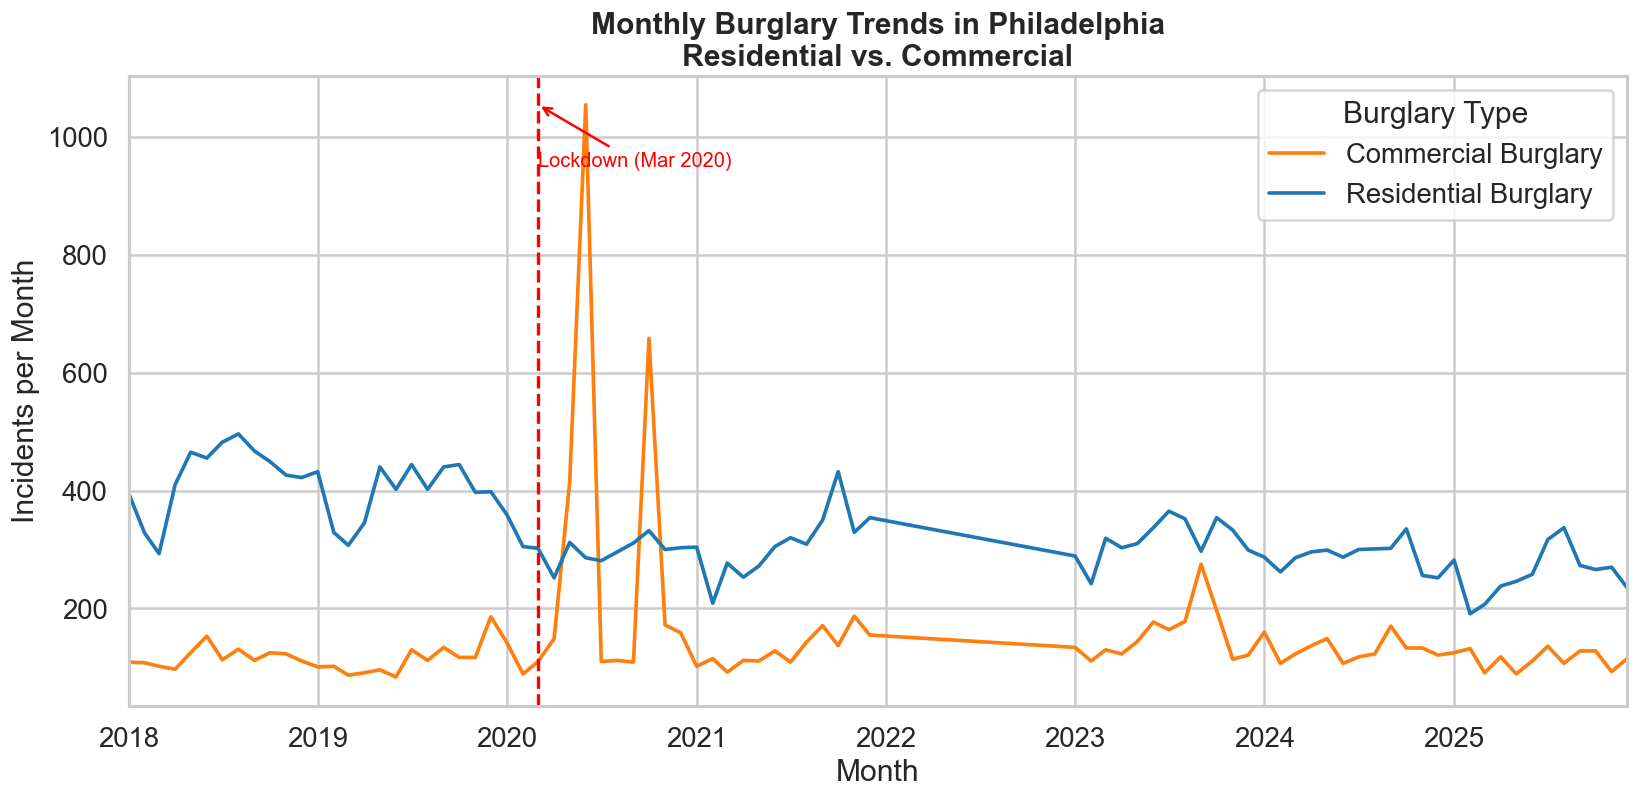

In [9]:
# Prepare time series for plotting
import matplotlib.pyplot as plt

burglary_ts = (
    df_period.dropna(subset=['burglary_type'])
    .groupby(['month', 'burglary_type'])
    .size()
    .reset_index(name='incidents')
)

# Pivot for lines
burglary_pivot = burglary_ts.pivot(index='month', columns='burglary_type', values='incidents').fillna(0)

fig, ax = plt.subplots(figsize=(14, 7))
colors = {
    'Residential Burglary': '#1f77b4',
    'Commercial Burglary': '#ff7f0e'
}

for col in burglary_pivot.columns:
    ax.plot(burglary_pivot.index, burglary_pivot[col], label=col, linewidth=2.2, color=colors.get(col))

# Lockdown annotation
lockdown_date = pd.Timestamp('2020-03-01')
ax.axvline(lockdown_date, color='red', linestyle='--', linewidth=2)
ax.annotate(
    'Lockdown (Mar 2020)',
    xy=(lockdown_date, burglary_pivot.max().max()),
    xytext=(lockdown_date, burglary_pivot.max().max() * 0.9),
    arrowprops=dict(arrowstyle='->', color='red'),
    color='red',
    fontsize=12,
    ha='left'
)

ax.set_title('Monthly Burglary Trends in Philadelphia\nResidential vs. Commercial', fontweight='bold')
ax.set_xlabel('Month')
ax.set_ylabel('Incidents per Month')
ax.legend(title='Burglary Type')
ax.set_xlim(burglary_pivot.index.min(), burglary_pivot.index.max())

fig.tight_layout()
output_path = REPORTS_DIR / 'covid_lockdown_burglary_trends.png'
fig.savefig(output_path, bbox_inches='tight')
print('Saved chart to', output_path)

## Insights <a id="insights"></a>
Quantify the displacement effect by comparing monthly averages before vs. during lockdowns for each burglary subtype.

In [10]:
# Displacement effect metrics
summary = period_burglary_summary.pivot(index='burglary_type', columns='period', values='monthly_avg')

summary['Change During vs Before (%)'] = (
    (summary['During (2020-2021)'] - summary['Before (2018-2019)'])
    / summary['Before (2018-2019)'] * 100
)

summary['Change After vs During (%)'] = (
    (summary['After (2023-Present)'] - summary['During (2020-2021)'])
    / summary['During (2020-2021)'] * 100
)

display(summary.round(2))

period,After (2023-Present),Before (2018-2019),During (2020-2021),Change During vs Before (%),Change After vs During (%)
burglary_type,,,,,
Commercial Burglary,133.94,115.25,201.67,74.98,-33.58
Residential Burglary,288.42,411.21,306.38,-25.49,-5.86


### Interpretation
- If **Residential Burglary** decreases during 2020–2021 while **Commercial Burglary** increases, this supports a displacement effect.
- Use the table above to compare the percentage changes in the **During vs Before** column.
- For the after period, check whether commercial burglary stays elevated or returns to pre-lockdown levels.

## Conclusion <a id="conclusion"></a>
This notebook provides a structured comparison of crime patterns before, during, and after COVID-19 lockdowns, with a specific focus on burglary displacement. The results combine period summaries with a time-series visualization annotated to March 2020.

## Completion Checklist <a id="completion-checklist"></a>
- [ ] Notebook executed end-to-end with no errors
- [ ] Outputs preserved (do not clear outputs)
- [ ] Chart saved to `reports/covid_lockdown_burglary_trends.png`
- [ ] Results reviewed for displacement effect
- [ ] `docs/NOTEBOOK_COMPLETION_REPORT.md` updated
- [ ] `docs/NOTEBOOK_QUICK_REFERENCE.md` updated